<a href="https://colab.research.google.com/github/harikrishnareddymallavarapu/Masters/blob/main/Masters_5_NMF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install pyLDAvis==2.1.2
!python -m spacy download en_core_web_md

In [2]:
from google.colab import drive
drive.mount('/content/drive')
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive
Mounted at /content/drive


In [3]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
# import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline


/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


In [4]:
import pickle
pkl_file = open('drive/My Drive/Top-Ex/articles_cleansed.pkl', 'rb')
articles = pickle.load(pkl_file)
pkl_file.close()

In [5]:
print(articles.head())

                                             cleanseText                                       cleanseText2
44480  [trump, say, massive, tax, plan, come, week, p...  [trump, say, ', massive, ', tax, plan, come, w...
8195   [chicago, police, no, regard, minority, live, ...  [chicago, police, ', no, regard, ', minority, ...
10464  [concussion, lead, sleep, problem, year, peopl...  [concussion, lead, sleep, problem, year, peopl...
19198  [trump, joke, crude, comment, woman, watch, in...  [trump, :, joke, crude, comment, woman, ', -PR...
17793  [beyoncé, drop, coachella, duh, happen, friend...  [beyoncé, drop, coachella, ,, duh, ', happen, ...


In [6]:
articles.shape

(50000, 2)

In [7]:
# let us see the top 20 again after cleaning
articles['cleanseText2'] = articles.cleanseText.apply(lambda x: ' '.join(w for w in x))  

freq_NN = pd.Series(' '.join(articles['cleanseText2']).split()).value_counts()[:20]
freq_NN

say          267720
trump        171045
not          133628
be           108226
people        89897
do            81762
year          81649
new           77017
like          65350
president     63356
time          61544
state         60038
go            58674
tell          52736
clinton       50268
come          49700
know          49467
that          48484
think         46204
work          46132
dtype: int64

In [8]:
#Use CountVectorizer to get bigrams to visualize
#Use CountVectorizer to get bigrams to visualize
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(max_df = 0.95, min_df = 2, max_features=10000, ngram_range=(1,3))
X = cv.fit_transform(articles['cleanseText2'])

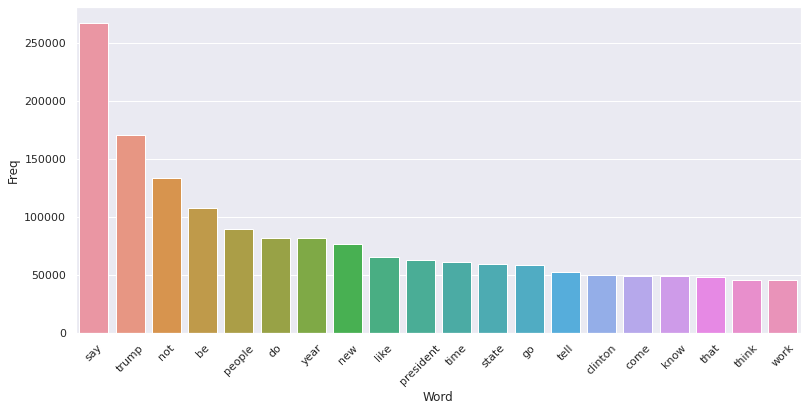

In [9]:
# Most frequently occuring words
def get_top_n_words(corpus,n=None):
    vec = CountVectorizer().fit(articles['cleanseText2'])
    bag_of_words=vec.transform(articles['cleanseText2'])
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word , idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
# Convert most freq words to datafame for visuals

top_words = get_top_n_words(articles['cleanseText2'], n=20)
top_df = pd.DataFrame(top_words)
top_df.columns = ['Word', 'Freq']

# barplot of most freq words
import seaborn as sns
sns.set(rc={'figure.figsize':(13,6)})
g = sns.barplot(x='Word', y='Freq', data=top_df)
g.set_xticklabels(g.get_xticklabels(), rotation=45)
fig = g.get_figure()
fig.savefig("sns_output.png")


In [10]:
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer

# use tfidf by removing tokens that don't appear in at least 50 documents
vect = TfidfVectorizer(min_df=50, stop_words='english')

# Fit and transform
X = vect.fit_transform(articles['cleanseText2'])

In [11]:
# Create an NMF instance: model
# the 10 components will be the topics
model = NMF(n_components=10, random_state=5)
# Fit the model to TF-IDF
model.fit(X)
# Transform the TF-IDF: nmf_features
nmf_features = model.transform(X)

In [12]:
components_df = pd.DataFrame(model.components_, columns=vect.get_feature_names())
components_df

,00,000,01,02,03,04,05,06,07,08,09,10,100,1000,100th,101,102,103,104,105,106,107,108,109,10th,11,110,111,112,113,114,115,116,117,118,119,11th,12,120,121,...,yo,yoga,yogurt,york,yorker,yorkers,yougov,young,younger,youngster,youth,youthful,youtube,ypg,yuan,zach,zachary,zack,zakaria,zeal,zealand,zeitung,zen,zengerle,zero,zetas,zhang,zieminski,zika,zimbabwe,zimmerman,zinke,zionist,zip,zoe,zombie,zone,zoo,zoom,zuckerberg
0,0.004441,0.180466,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.163039,0.102988,0.003329,0.003721,0.005101,0.003269,0.002340,0.001297,0.004182,0.001858,0.001447,0.004409,0.001675,0.015442,0.068182,0.006216,0.002270,0.001943,0.001607,0.002724,0.005911,0.002505,0.002993,0.001389,0.001178,0.011658,0.082914,0.008634,0.002320,...,0.007892,0.025438,0.009507,0.237162,0.033349,0.017228,0.000503,0.425587,0.005829,0.015800,0.069336,0.010769,0.064643,0.00000,0.000000,0.009258,0.003606,0.009618,0.001073,0.003751,0.019847,0.000021,0.008561,0.000000,0.032211,0.000000,0.009327,0.000000,0.106924,0.005687,0.003306,0.000000,0.000806,0.010139,0.011355,0.020854,0.028396,0.031613,0.007337,0.042324
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.029838,0.000000,0.007441,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000187,0.000000,0.009161,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002687,0.000000,...,0.000000,0.000000,0.000000,0.091047,0.013611,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000774,0.010278,0.000068,0.000000,0.000000,0.000000,0.000570,0.008012,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007532,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.051463,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002711,0.00000,0.010097,0.005239,0.000161,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001360,0.000000,0.000000,0.022935,0.004127,0.000000,0.001771,0.000848,0.000000,0.000000,0.001626,0.000000,0.000000,0.000162,0.000565,0.008228,0.000000,0.001050,...,0.000287,0.000975,0.000000,0.075316,0.004102,0.001353,0.000000,0.056654,0.000859,0.000000,0.005625,0.000863,0.002235,0.00000,0.000000,0.001453,0.000611,0.000000,0.000000,0.000079,0.000000,0.000000,0.000000,0.000000,0.007356,0.000000,0.000000,0.000000,0.000000,0.000000,0.002337,0.000000,0.000000,0.000000,0.000000,0.000000,0.001171,0.000000,0.000000,0.000000
3,0.011244,0.262383,0.018547,0.014339,0.015227,0.016775,0.021647,0.015209,0.015705,0.016927,0.01926,0.202265,0.084019,0.001874,0.000000,0.006693,0.007073,0.005593,0.006462,0.007260,0.006837,0.008163,0.004021,0.007624,0.002976,0.081550,0.012320,0.007590,0.007197,0.007188,0.004143,0.009405,0.004945,0.008521,0.008008,0.002922,0.001507,0.102015,0.012635,0.004361,...,0.000000,0.000731,0.001651,0.155292,0.000000,0.007949,0.004095,0.000000,0.000140,0.000000,0.000000,0.000000,0.011381,0.00000,0.039408,0.000000,0.000000,0.000189,0.000000,0.000000,0.014392,0.004093,0.000000,0.000000,0.026836,0.000000,0.003523,0.050827,0.000000,0.002383,0.000000,0.001374,0.000000,0.002439,0.000000,0.000287,0.021084,0.000000,0.001474,0.031140
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.001193,0.000000,0.000000,0.000000,0.000000,0.000097,0.000000,0.000000,0.000000,0.000000,0.000390,0.000000,0.000000,0.002071,0.012037,0.006230,0.000000,0.000000,0.002998,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.005246,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.059252,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003524,0.00000,0.000000,0.000000,0.001029,0.001003,0.000926,0.000425,0.000000,0.002275,0.000000,0.008634,0.008186,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000676,0.000000,0.000000,0.000000,0.000

In [13]:
for topic in range(components_df.shape[0]):
    tmp = components_df.iloc[topic]
    print(f'For topic {topic+1} the words with the highest value are:')
    print(tmp.nlargest(10))
    print('\n')

For topic 1 the words with the highest value are:
say       1.242653
like      1.101408
woman     1.073266
people    1.027515
think     0.826159
know      0.785107
year      0.751679
time      0.748525
work      0.701256
school    0.683547
Name: 0, dtype: float64


For topic 2 the words with the highest value are:
trump           4.503448
donald          0.771518
president       0.645763
campaign        0.436345
say             0.381894
republican      0.346428
white           0.322812
presidential    0.238987
house           0.238623
policy          0.233831
Name: 1, dtype: float64


For topic 3 the words with the highest value are:
clinton       3.620493
hillary       1.193331
sander        0.937850
campaign      0.526232
democratic    0.517126
email         0.493538
voter         0.366605
state         0.350022
obama         0.336874
bernie        0.335308
Name: 2, dtype: float64


For topic 4 the words with the highest value are:
percent    1.420312
company    1.094265
market     0

In [14]:
pkl_file = open('drive/My Drive/Top-Ex/lda_data_lemmatized.pkl', 'rb')
data_lemmatized = pickle.load(pkl_file)
pkl_file.close()

pkl_file = open('drive/My Drive/Top-Ex/lda_id2word.pkl', 'rb')
id2word = pickle.load(pkl_file)
pkl_file.close()

pkl_file = open('drive/My Drive/Top-Ex/lda_corpus.pkl', 'rb')
corpus = pickle.load(pkl_file)
pkl_file.close()

In [17]:
pip install "gensim==3.8.1"

     |████████████████████████████████| 24.2 MB 80 kB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [18]:
import gensim.downloader
from gensim import matutils, utils
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel, LdaModel, TfidfModel
from gensim.models.basemodel import BaseTopicModel
from gensim.models.nmf import Nmf as GensimNmf
from gensim.parsing.preprocessing import preprocess_string

In [19]:
from gensim.models.nmf import Nmf
nmf = Nmf(corpus, num_topics=50, kappa=0.1, eval_every=5) 

/usr/local/lib/python3.7/dist-packages/gensim/models/nmf.py:588: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  if isinstance(corpus, collections.Iterator) and self.passes > 1:


In [20]:
# Most frequently occuring words
def get_top_n_words(corpus,n=None):
    vec = CountVectorizer().fit(df1['cleaned'])
    bag_of_words=vec.transform(df1['cleaned'])
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word , idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
# Convert most freq words to datafame for visuals

top_words = get_top_n_words(df1['cleaned'], n=20)
top_df = pd.DataFrame(top_words)
top_df.columns = ['Word', 'Freq']

# barplot of most freq words
import seaborn as sns
sns.set(rc={'figure.figsize':(13,6)})
g = sns.barplot(x='Word', y='Freq', data=top_df)
g.set_xticklabels(g.get_xticklabels(), rotation=45)
fig = g.get_figure()
fig.savefig("sns_output.png")

NameError: ignored